# Doc 5 Vehicle-level Emission Factors

C:\Users\Ricky Chen\AppData\Local\Temp\ipykernel_12184\2841779172.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  set2_colors = cm.get_cmap('Set2')


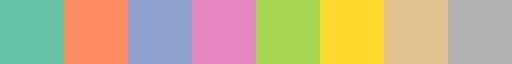

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

import matplotlib.cm as cm
set2_colors = cm.get_cmap('Set2')
set2_colors

## 1 Base OpMode ERs

### Data

In [3]:
# cycle
with open("data/cycles/opmode/CLTC_opmode.pkl", 'rb') as f:
    opmode_CLTC = pickle.load(f)
with open("data/cycles/opmode/Chengdu_opmode.pkl", 'rb') as f:
    opmode_Chengdu = pickle.load(f)

In [4]:
# brake types
brake_types = pd.read_csv("data/brake_types_2016_2024.csv")

### calculation

In [5]:
from calculator import ERCalculator
cal = ERCalculator()

In [6]:
base_er_cltc = pd.DataFrame(columns=['ICEV ERs', 'EV ERs'])
for year in range(2016, 2025):
    # get brake type distributions
    prop_drum_f_icev = brake_types[brake_types['year']==year]['ICEV frontB drum%'].values
    prop_drum_r_icev = brake_types[brake_types['year']==year]['ICEV rearB drum%'].values
    prop_drum_f_ev = brake_types[brake_types['year']==year]['EV frontB drum%'].values
    prop_drum_r_ev = brake_types[brake_types['year']==year]['EV rearB drum%'].values
    # calculate ICEV ERs
    icev_er = cal.calOpModeERs(
        OpModesInfo=opmode_CLTC,
        decelBins=np.arange(-4.5, 0.1, 0.1),
        prop_drum_f=prop_drum_f_icev,
        prop_drum_r=prop_drum_r_icev,
    )['ER[g/hr/veh]'].to_numpy()
    # calcualte EV ERs
    ev_er = cal.calOpModeERs(
        OpModesInfo=opmode_CLTC,
        decelBins=np.arange(-4.5, 0.1, 0.1),
        prop_drum_f=prop_drum_f_ev,
        prop_drum_r=prop_drum_r_ev,
    )['ER[g/hr/veh]'].to_numpy()
    # add data
    base_er_cltc.loc[year] = [icev_er, ev_er]

In [7]:
base_er_chengdu = pd.DataFrame(columns=['ICEV ERs', 'EV ERs'])
for year in range(2016, 2025):
    # get brake type distributions
    prop_drum_f_icev = brake_types[brake_types['year']==year]['ICEV frontB drum%'].values
    prop_drum_r_icev = brake_types[brake_types['year']==year]['ICEV rearB drum%'].values
    prop_drum_f_ev = brake_types[brake_types['year']==year]['EV frontB drum%'].values
    prop_drum_r_ev = brake_types[brake_types['year']==year]['EV rearB drum%'].values
    # calculate ICEV ERs
    icev_er = cal.calOpModeERs(
        OpModesInfo=opmode_Chengdu,
        decelBins=np.arange(-4.5, 0.1, 0.1),
        prop_drum_f=prop_drum_f_icev,
        prop_drum_r=prop_drum_r_icev,
    )['ER[g/hr/veh]'].to_numpy()
    # calcualte EV ERs
    ev_er = cal.calOpModeERs(
        OpModesInfo=opmode_Chengdu,
        decelBins=np.arange(-4.5, 0.1, 0.1),
        prop_drum_f=prop_drum_f_ev,
        prop_drum_r=prop_drum_r_ev,
    )['ER[g/hr/veh]'].to_numpy()
    # add data
    base_er_chengdu.loc[year] = [icev_er, ev_er]

## 2 Regenerative braking ERs adjustment

In [8]:
# reg braking intensity
with open("data/ev records/opmodes_ei5.pkl", 'rb') as f:
    opmode_ei5 = pickle.load(f)
with open("data/ev records/opmodes_modelY.pkl", 'rb') as f:
    opmode_modely = pickle.load(f)

reg_weak = opmode_ei5['reg_intensity'].values
reg_strong = opmode_modely['reg_intensity'].values

In [9]:
# adjust ERs for regenerative braking
base_er_cltc['EV ERs weak'] = base_er_cltc['EV ERs'].apply(lambda x: x * (1 - reg_weak))
base_er_cltc['EV ERs strong'] = base_er_cltc['EV ERs'].apply(lambda x: x * (1 - reg_strong))

base_er_chengdu['EV ERs weak'] = base_er_chengdu['EV ERs'].apply(lambda x: x * (1 - reg_weak))
base_er_chengdu['EV ERs strong'] = base_er_chengdu['EV ERs'].apply(lambda x: x * (1 - reg_strong))

In [10]:
# # save
# with open("data/base_opmode_er_cltc.pkl", 'wb') as f:
#     pickle.dump(base_er_cltc, f)

# with open("data/base_opmode_er_chengdu.pkl", 'wb') as f:
#     pickle.dump(base_er_chengdu, f)

## 3 EF calculation

### CLTC

In [11]:
# parameters for CLTC
cycle_cltc = pd.read_csv("data/cycles/raw/CLTC-P.csv")
durantion_cltc = cycle_cltc['Time/(s)'].max()  # s
mileage_cltc = cycle_cltc['Speed/(km/h)'].sum() / 3600  # km
opmode_dist_cltc = (opmode_CLTC['trajCount'] / opmode_CLTC['trajCount'].sum()).to_numpy()

In [12]:
base_ef_cltc = pd.DataFrame(columns=['ICEV EF', 'EV weak EF', 'EV strong EF'])
base_ef_cltc['ICEV EF'] = base_er_cltc['ICEV ERs'].apply(
    lambda x: (x * opmode_dist_cltc).sum() * durantion_cltc / 3600 / mileage_cltc * 1000)  # mg/km
base_ef_cltc['EV weak EF'] = base_er_cltc['EV ERs weak'].apply(
    lambda x: (x * opmode_dist_cltc).sum() * durantion_cltc / 3600 / mileage_cltc * 1000)  # mg/km
base_ef_cltc['EV strong EF'] = base_er_cltc['EV ERs strong'].apply(
    lambda x: (x * opmode_dist_cltc).sum() * durantion_cltc / 3600 / mileage_cltc * 1000)  # mg/km
base_ef_cltc

,ICEV EF,EV weak EF,EV strong EF
2016,1.251045,1.116275,0.037419
2017,1.257375,1.076860,0.036098
2018,1.263009,1.077210,0.036110
2019,1.267937,1.098483,0.036823
2020,1.273376,1.105186,0.037048
2021,1.278942,1.100058,0.036876
2022,1.284392,1.106298,0.037085
2023,1.289722,1.117048,0.037445
2024,1.295820,1.125629,0.037733


### Chengdu

In [13]:
with open('data/cycles/raw/cycle_info_chengdu.pkl', 'rb') as f:
    cycle_chengdu = pickle.load(f)
cycle_chengdu
durantion_chengdu = cycle_chengdu.loc[0, 'trajCount']  # s
mileage_chengdu = cycle_chengdu.loc[0, 'mileage']  # km
opmode_dist_chengdu = (opmode_Chengdu['trajCount'] / opmode_Chengdu['trajCount'].sum()).to_numpy()

In [14]:
base_ef_chengdu = pd.DataFrame(columns=['ICEV EF', 'EV weak EF', 'EV strong EF'])
base_ef_chengdu['ICEV EF'] = base_er_chengdu['ICEV ERs'].apply(
    lambda x: (x * opmode_dist_chengdu).sum() * durantion_chengdu / 3600 / mileage_chengdu * 1000)  # mg/km
base_ef_chengdu['EV weak EF'] = base_er_chengdu['EV ERs weak'].apply(
    lambda x: (x * opmode_dist_chengdu).sum() * durantion_chengdu / 3600 / mileage_chengdu * 1000)  # mg/km
base_ef_chengdu['EV strong EF'] = base_er_chengdu['EV ERs strong'].apply(
    lambda x: (x * opmode_dist_chengdu).sum() * durantion_chengdu / 3600 / mileage_chengdu * 1000)  # mg/km
base_ef_chengdu

,ICEV EF,EV weak EF,EV strong EF
2016,28.871433,27.419184,0.952991
2017,29.018016,26.447825,0.919229
2018,29.148492,26.456448,0.919528
2019,29.262618,26.980712,0.937750
2020,29.388581,27.145910,0.943492
2021,29.517474,27.019525,0.939100
2022,29.643698,27.173301,0.944444
2023,29.767127,27.438234,0.953653
2024,29.908365,27.649701,0.961003


## 4 Curb weight EF adjustment

In [15]:
weights = pd.read_csv("data/weights_2016_2024.csv")
weights.set_index('year', inplace=True)

In [16]:
weights

,ICEV & others,BEV,PHEV,bev%,EV
year,,,,,
2016,1375.485912,1459.397631,2027.549872,0.8120,1566.210252
2017,1380.353571,1287.705257,1976.016297,0.8120,1417.107733
2018,1385.049715,1343.832207,1969.227577,0.8120,1461.406536
2019,1390.412302,1398.794581,1929.503863,0.8120,1498.567926
2020,1398.503328,1412.567781,1907.781893,0.8100,1506.658462
2021,1406.599983,1452.459231,1940.672173,0.8160,1542.290412
2022,1415.529120,1498.356690,1955.013527,0.7980,1590.601371
2023,1427.866239,1550.608698,1957.340179,0.7600,1648.224253
2024,1444.603455,1585.327999,1931.299778,0.7034,1687.943228


In [17]:
def weight_adjust(EF, weight, assumption, weight_ref=1497):
    """
    Adjust calculated EF according to weight.
    """
    if assumption == 'linear':
        a = 1
    elif assumption == 'power':
        a = 1.9
    return EF * (weight/weight_ref)**(1/a)

In [18]:
def calculate_weight_adjusted_ef(cycle, weights):
    """
    Calculate weight-adjusted emission factors.
    """
    EF = pd.DataFrame()
    EF['ICEV EF linear'] = cycle.apply(
        lambda x: weight_adjust(x['ICEV EF'], weights.loc[x.name, 'ICEV & others'], 'linear'),
        axis=1)
    EF['ICEV EF power'] = cycle.apply(
        lambda x: weight_adjust(x['ICEV EF'], weights.loc[x.name, 'ICEV & others'], 'power'),
        axis=1)
    EF['EV weak EF linear'] = cycle.apply(
        lambda x: weight_adjust(x['EV weak EF'], weights.loc[x.name, 'EV'], 'linear'),
        axis=1)
    EF['EV weak EF power'] = cycle.apply(
        lambda x: weight_adjust(x['EV weak EF'], weights.loc[x.name, 'EV'], 'power'),
        axis=1)
    EF['EV strong EF linear'] = cycle.apply(
        lambda x: weight_adjust(x['EV strong EF'], weights.loc[x.name, 'EV'], 'linear'),
        axis=1)
    EF['EV strong EF power'] = cycle.apply(
        lambda x: weight_adjust(x['EV strong EF'], weights.loc[x.name, 'EV'], 'power'),
        axis=1)
    return EF

In [19]:
adjusted_ef_cltc = calculate_weight_adjusted_ef(base_ef_cltc, weights)
adjusted_ef_cltc

,ICEV EF linear,ICEV EF power,EV weak EF linear,EV weak EF power,EV strong EF linear,EV strong EF power
2016,1.149496,1.196528,1.167883,1.143146,0.039149,0.038320
2017,1.159400,1.204819,1.019390,1.046220,0.034171,0.035071
2018,1.168557,1.212383,1.051598,1.063653,0.035251,0.035655
2019,1.177659,1.219591,1.099634,1.099089,0.036861,0.036843
2020,1.189593,1.228569,1.112317,1.108934,0.037287,0.037173
2021,1.201709,1.237694,1.133339,1.117451,0.037991,0.037459
2022,1.214492,1.247115,1.175470,1.142181,0.039404,0.038288
2023,1.230160,1.258023,1.229890,1.175084,0.041228,0.039391
2024,1.250465,1.271748,1.269203,1.199044,0.042546,0.040194


In [20]:
adjusted_ef_chengdu = calculate_weight_adjusted_ef(base_ef_chengdu, weights)
adjusted_ef_chengdu

,ICEV EF linear,ICEV EF power,EV weak EF linear,EV weak EF power,EV strong EF linear,EV strong EF power
2016,26.527889,27.613280,28.686845,28.079230,0.997050,0.975931
2017,26.756929,27.805125,25.036351,25.695299,0.870171,0.893074
2018,26.968678,27.980118,25.827405,26.123486,0.897665,0.907956
2019,27.179094,28.146858,27.008971,26.995582,0.938733,0.938267
2020,27.454929,28.354476,27.321052,27.237950,0.949580,0.946691
2021,27.734989,28.565492,27.836977,27.446725,0.967511,0.953947
2022,28.030406,28.783350,28.872337,28.054680,1.003497,0.975078
2023,28.392436,29.035507,30.209995,28.863784,1.049989,1.003200
2024,28.861542,29.352758,31.176437,29.453062,1.083579,1.023681


### analysis - EF increase rate

ICEV

In [21]:
# increase
adjusted_ef_cltc['ICEV EF'] = (adjusted_ef_cltc['ICEV EF linear'] + adjusted_ef_cltc['ICEV EF power']) / 2
ef_increase_cltc = (adjusted_ef_cltc.loc[2024]['ICEV EF'] - adjusted_ef_cltc.loc[2016]['ICEV EF'])
ef_increase_rate_cltc = ef_increase_cltc / adjusted_ef_cltc.loc[2016]['ICEV EF']
print("cltc ef increase: %.3f mg/km" % ef_increase_cltc)
print("cltc ef increase rate: %.3f" % ef_increase_rate_cltc)

cltc ef increase: 0.088 mg/km
cltc ef increase rate: 0.075


In [22]:
# increase
adjusted_ef_chengdu['ICEV EF'] = (adjusted_ef_chengdu['ICEV EF linear'] + adjusted_ef_chengdu['ICEV EF power']) / 2
ef_increase_chengdu = (adjusted_ef_chengdu.loc[2024]['ICEV EF'] - adjusted_ef_chengdu.loc[2016]['ICEV EF'])
ef_increase_rate_chengdu = ef_increase_chengdu / adjusted_ef_chengdu.loc[2016]['ICEV EF']
print("chengdu ef increase: %.3f mg/km" % ef_increase_chengdu)
print("chengdu ef increase rate: %.3f" % ef_increase_rate_chengdu)

chengdu ef increase: 2.037 mg/km
chengdu ef increase rate: 0.075


In [23]:
weight_increase = weights.loc[2024, 'ICEV & others'] - weights.loc[2016, 'ICEV & others']
weight_increase_rate = (weights.loc[2024, 'ICEV & others'] - weights.loc[2016, 'ICEV & others']) / weights.loc[2016, 'ICEV & others']
print("weight increase: %.2f kg" % weight_increase)
print("weight increase rate: %.3f" % weight_increase_rate)

weight increase: 69.12 kg
weight increase rate: 0.050


EV

In [24]:
# increase
adjusted_ef_cltc['EV weak EF'] = (adjusted_ef_cltc['EV weak EF linear'] + adjusted_ef_cltc['EV weak EF power']) / 2
adjusted_ef_cltc['EV strong EF'] = (adjusted_ef_cltc['EV strong EF linear'] + adjusted_ef_cltc['EV strong EF power']) / 2
ef_increase_weak_cltc = (adjusted_ef_cltc.loc[2024]['EV weak EF'] - adjusted_ef_cltc.loc[2017]['EV weak EF'])
ef_increase_strong_cltc = (adjusted_ef_cltc.loc[2024]['EV strong EF'] - adjusted_ef_cltc.loc[2017]['EV strong EF'])
ef_increase_weak_rate_cltc = ef_increase_weak_cltc / adjusted_ef_cltc.loc[2017]['EV weak EF']
ef_increase_strong_rate_cltc = ef_increase_strong_cltc / adjusted_ef_cltc.loc[2017]['EV strong EF']
print("cltc ev weak ef increase: %.3f mg/km" % ef_increase_weak_cltc)
print("cltc ev weak ef increase rate: %.3f" % ef_increase_weak_rate_cltc)
print("cltc ev strong ef increase: %.3f mg/km" % ef_increase_strong_cltc)
print("cltc ev strong ef increase rate: %.3f" % ef_increase_strong_rate_cltc)

cltc ev weak ef increase: 0.201 mg/km
cltc ev weak ef increase rate: 0.195
cltc ev strong ef increase: 0.007 mg/km
cltc ev strong ef increase rate: 0.195


In [25]:
weight_increase = weights.loc[2024, 'EV'] - weights.loc[2017, 'EV']
weight_increase_rate = (weights.loc[2024, 'EV'] - weights.loc[2017, 'EV']) / weights.loc[2017, 'EV']
print("weight increase: %.2f kg" % weight_increase)
print("weight increase rate: %.3f" % weight_increase_rate)

weight increase: 270.84 kg
weight increase rate: 0.191


### Analysis - Reg. Braking

In [28]:
adjusted_ef_chengdu['EV weak EF'] = (adjusted_ef_chengdu['EV weak EF linear'] + adjusted_ef_chengdu['EV weak EF power']) / 2
adjusted_ef_chengdu['EV strong EF'] = (adjusted_ef_chengdu['EV strong EF linear'] + adjusted_ef_chengdu['EV strong EF power']) / 2

In [29]:
# strong reg.
ef_red_rate_cltc = ((adjusted_ef_cltc['ICEV EF'] - adjusted_ef_cltc['EV strong EF']) / adjusted_ef_cltc['ICEV EF']).mean()
ef_red_rate_chengdu = ((adjusted_ef_chengdu['ICEV EF'] - adjusted_ef_chengdu['EV strong EF']) / adjusted_ef_chengdu['ICEV EF']).mean()
print("avg. strong reg. ef reduction rate compared to icev: %.3f" % ((ef_red_rate_cltc + ef_red_rate_chengdu)/2))

avg. strong reg. ef reduction rate compared to icev: 0.967


In [31]:
# weak reg.
(adjusted_ef_cltc['EV weak EF'] - adjusted_ef_cltc['ICEV EF']) / adjusted_ef_cltc['ICEV EF']

2016   -0.014916
2017   -0.126304
2018   -0.111590
2019   -0.082815
2020   -0.081430
2021   -0.077319
2022   -0.058480
2023   -0.033442
2024   -0.021396
dtype: float64

In [32]:
(adjusted_ef_chengdu['EV weak EF'] - adjusted_ef_chengdu['ICEV EF']) / adjusted_ef_chengdu['ICEV EF']

2016    0.048483
2017   -0.070203
2018   -0.054558
2019   -0.023884
2020   -0.022405
2021   -0.018060
2022    0.001994
2023    0.028659
2024    0.041488
dtype: float64

### Plot

In [19]:
# save
with open("data/vehicle_ef_cltc.pkl", 'wb') as f:
    pickle.dump(adjusted_ef_cltc, f)
with open("data/vehicle_ef_chengdu.pkl", 'wb') as f:
    pickle.dump(adjusted_ef_chengdu, f)

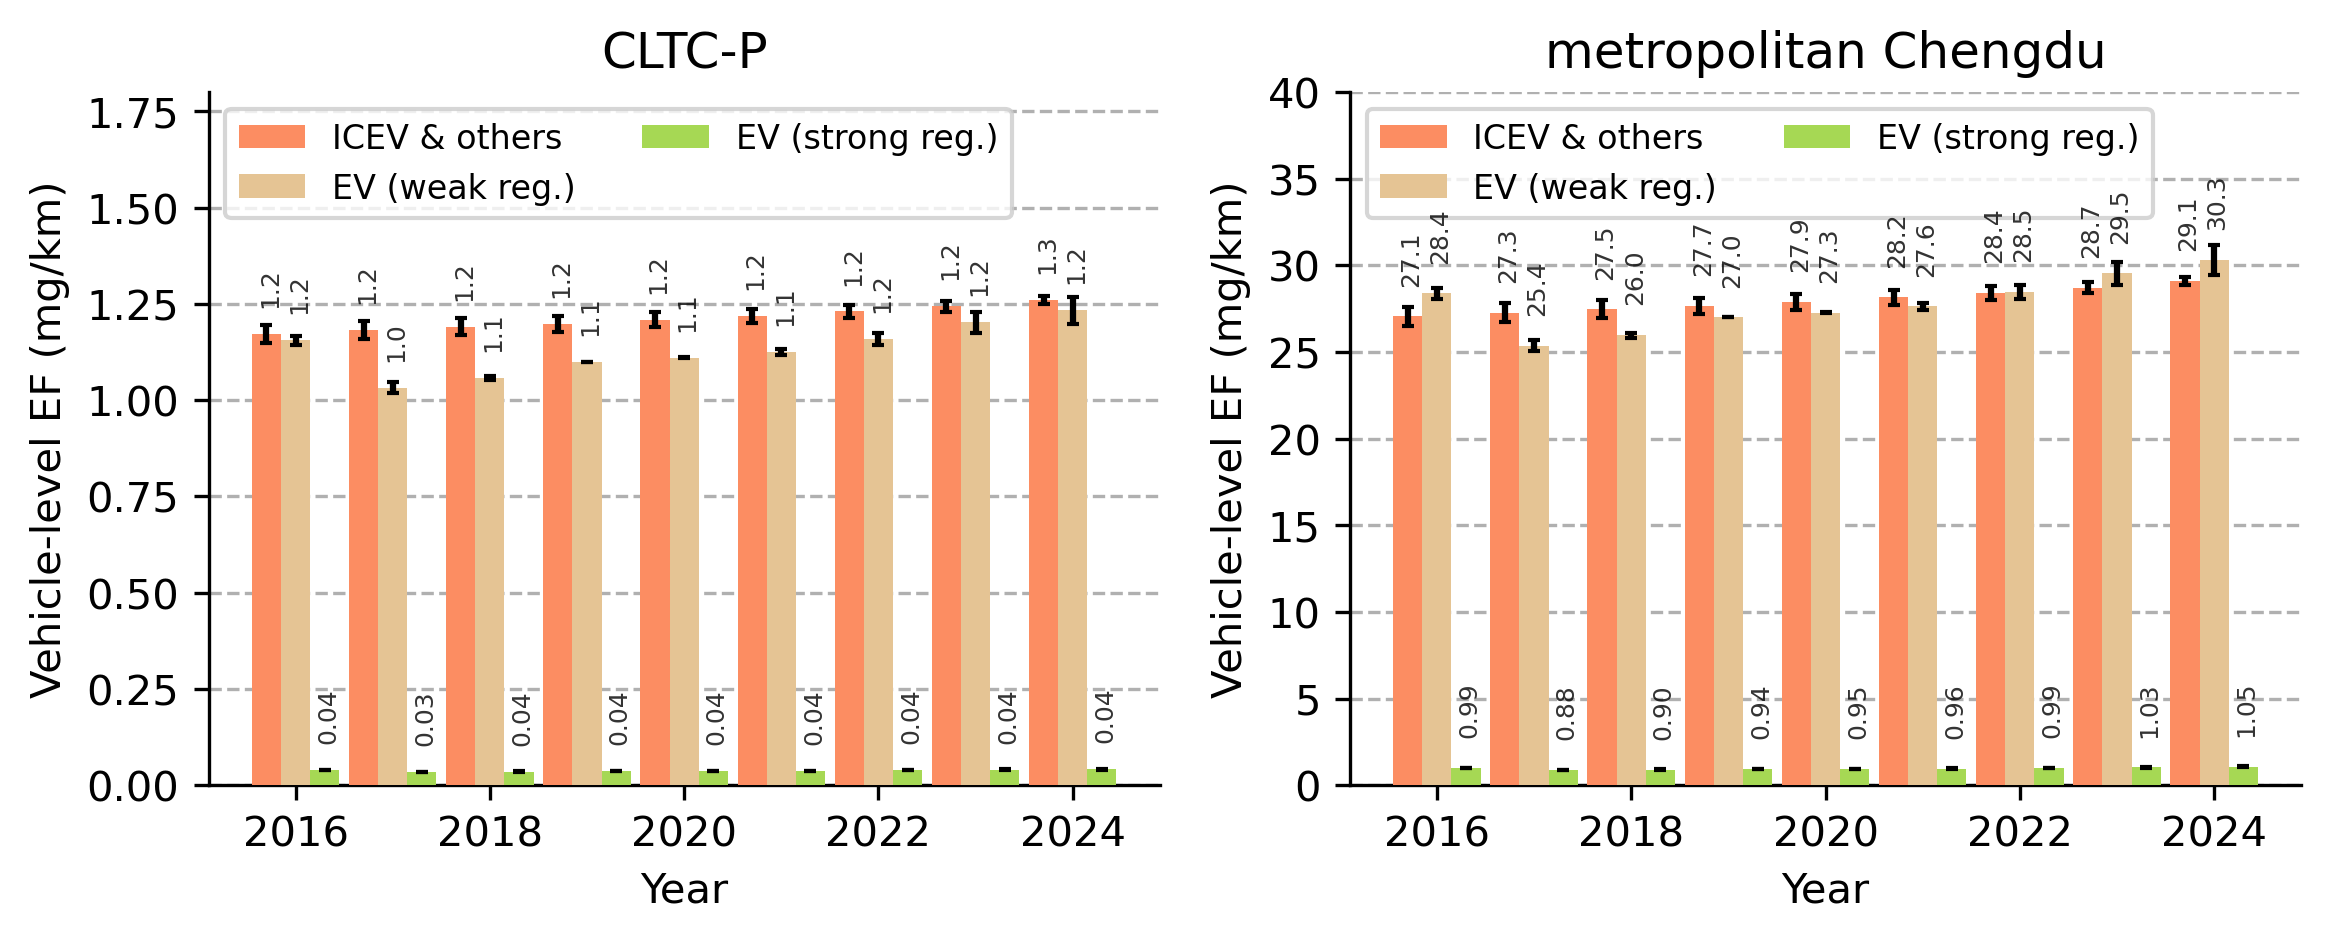

In [19]:
# vehicle-level EF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3))

# colors
color_icev = set2_colors(1)
color_ev_weak = set2_colors(6)
color_ev_strong = set2_colors(4)

# bar function
def bar(ax, ef, fuel, width, pos, label, color):
    x = ef.index + width * pos
    linear = ef['%s EF linear' % fuel]
    power = ef['%s EF power' % fuel]
    y = (linear+power)/2
    yerr_lower = y - np.min([linear, power], axis=0)
    yerr_upper = np.max([linear, power], axis=0) - y
    yerr = np.vstack([yerr_lower, yerr_upper])
    bar_ = ax.bar(x, y, width=width, label=label, color=color, zorder=10)
    ax.errorbar(x, y, yerr=yerr, fmt='none', color='black', capsize=1.5, zorder=20)
    return bar_ 

width = 0.3

# fig 1: cltc
## ICEV
bar_1 = bar(ax1, adjusted_ef_cltc, 'ICEV', width, -1, 'ICEV & others', color_icev)
## EV weak
bar_2 = bar(ax1, adjusted_ef_cltc, 'EV weak', width, 0, 'EV (weak reg.)', color_ev_weak)
## EV strong
bar_3 = bar(ax1, adjusted_ef_cltc, 'EV strong', width, 1, 'EV (strong reg.)', color_ev_strong)
## axis
ax1.set_title('CLTC-P')
ax1.set_ylim(0,1.8)

# fig 2: chengdu
## ICEV
bar_4 = bar(ax2, adjusted_ef_chengdu, 'ICEV', width, -1, 'ICEV & others', color_icev)
## EV weak
bar_5 = bar(ax2, adjusted_ef_chengdu, 'EV weak', width, 0, 'EV (weak reg.)', color_ev_weak)
## EV strong
bar_6 = bar(ax2, adjusted_ef_chengdu, 'EV strong', width, 1, 'EV (strong reg.)', color_ev_strong)
## axis
ax2.set_title('metropolitan Chengdu')
ax2.set_ylim(0,40)

# annotations
for bars in [bar_1, bar_2]:
    for bar in bars:
        # annotate the height of each bar
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}', zorder=20,
                    xy=(bar.get_x()+0.55, height+0.08),
                    xytext=(-8.5,-1), fontsize=6, rotation=90,
                    textcoords="offset points", alpha=0.8, 
                    ha='center', va='bottom')
for bars in [bar_3]:
    for bar in bars:
        # annotate the height of each bar
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}', zorder=20,
                    xy=(bar.get_x()+0.55, height+0.08),
                    xytext=(-8.5,-1), fontsize=6, rotation=90,
                    textcoords="offset points", alpha=0.8,
                    ha='center', va='bottom')
for bars in [bar_4, bar_5]:
    for bar in bars:
        # annotate the height of each bar
        height = bar.get_height()
        ax2.annotate(f'{height:.1f}', zorder=20,
                    xy=(bar.get_x()+0.55, height+2),
                    xytext=(-8.5,-1), fontsize=6, rotation=90,
                    textcoords="offset points", alpha=0.8,
                    ha='center', va='bottom')
for bars in [bar_6]:
    for bar in bars:
        # annotate the height of each bar
        height = bar.get_height()
        ax2.annotate(f'{height:.2f}', zorder=20,
                    xy=(bar.get_x()+0.55, height+2),
                    xytext=(-8.5,-1), fontsize=6, rotation=90,
                    textcoords="offset points", alpha=0.8,
                    ha='center', va='bottom')
# axis settings
for ax in (ax1, ax2):
    ax.set_xlabel('Year')
    ax.set_ylabel('Vehicle-level EF (mg/km)')
    ax.legend(loc='upper left', ncols=2, fontsize=8)
    ax.grid(axis='y', linestyle="--", zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()
fig.savefig('figures/vehicle ef.jpg', bbox_inches='tight', dpi=1000)

---

## Cycle compariosn

### OpMode ER contribution rate

In [3]:
# cycle
with open("data/cycles/opmode/CLTC_opmode.pkl", 'rb') as f:
    opmode_CLTC = pickle.load(f)
with open("data/cycles/opmode/Chengdu_opmode.pkl", 'rb') as f:
    opmode_Chengdu = pickle.load(f)

In [4]:
# opmode er
with open("data/base_opmode_er_cltc.pkl", 'rb') as f:
    opmode_er_cltc = pickle.load(f)
with open("data/base_opmode_er_chengdu.pkl", 'rb') as f:
    opmode_er_chengdu = pickle.load(f)

# opmode distribution
opmode_dist_cltc = opmode_CLTC['trajCount'] / opmode_CLTC['trajCount'].sum()
opmode_dist_chengdu = opmode_Chengdu['trajCount'] / opmode_Chengdu['trajCount'].sum()

# vehicle er
icev_er_cltc = opmode_er_cltc['ICEV ERs'].apply(lambda x: (x * opmode_dist_cltc).sum())
icev_er_chengdu = opmode_er_chengdu['ICEV ERs'].apply(lambda x: (x * opmode_dist_chengdu).sum())

# avg opmode er contribution
opmode_er_contribution_cltc = (opmode_er_cltc['ICEV ERs'].apply(lambda x: x * opmode_dist_cltc.values) / icev_er_cltc).mean()
opmode_er_contribution_chengdu = (opmode_er_chengdu['ICEV ERs'].apply(lambda x: x * opmode_dist_chengdu.values) / icev_er_chengdu).mean()

In [225]:
opmode_er_contribution_cltc

array([8.56311408e-01, 6.01425913e-04, 9.14603220e-02, 2.39568590e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.42090238e-02, 2.07379742e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.97087240e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [226]:
opmode_er_contribution_chengdu

array([9.79301583e-01, 9.27633639e-05, 1.61301102e-02, 2.00425753e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.28550866e-03, 2.41309081e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.45861326e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [227]:
opmode_er_cltc['ICEV ERs'].mean()

array([7.01800509e-01, 9.41636221e-05, 2.41894447e-02, 4.49255580e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.93479532e-02, 1.63890548e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.92815872e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [228]:
opmode_er_chengdu['ICEV ERs'].mean()

array([5.04968744e+00, 2.11335451e-04, 5.79786156e-02, 8.27255544e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.59352347e-02, 6.96155152e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.28108278e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [5]:
opmode_er_chengdu['ICEV ERs'].mean()[0] / opmode_er_cltc['ICEV ERs'].mean()[0]

7.195331686899046

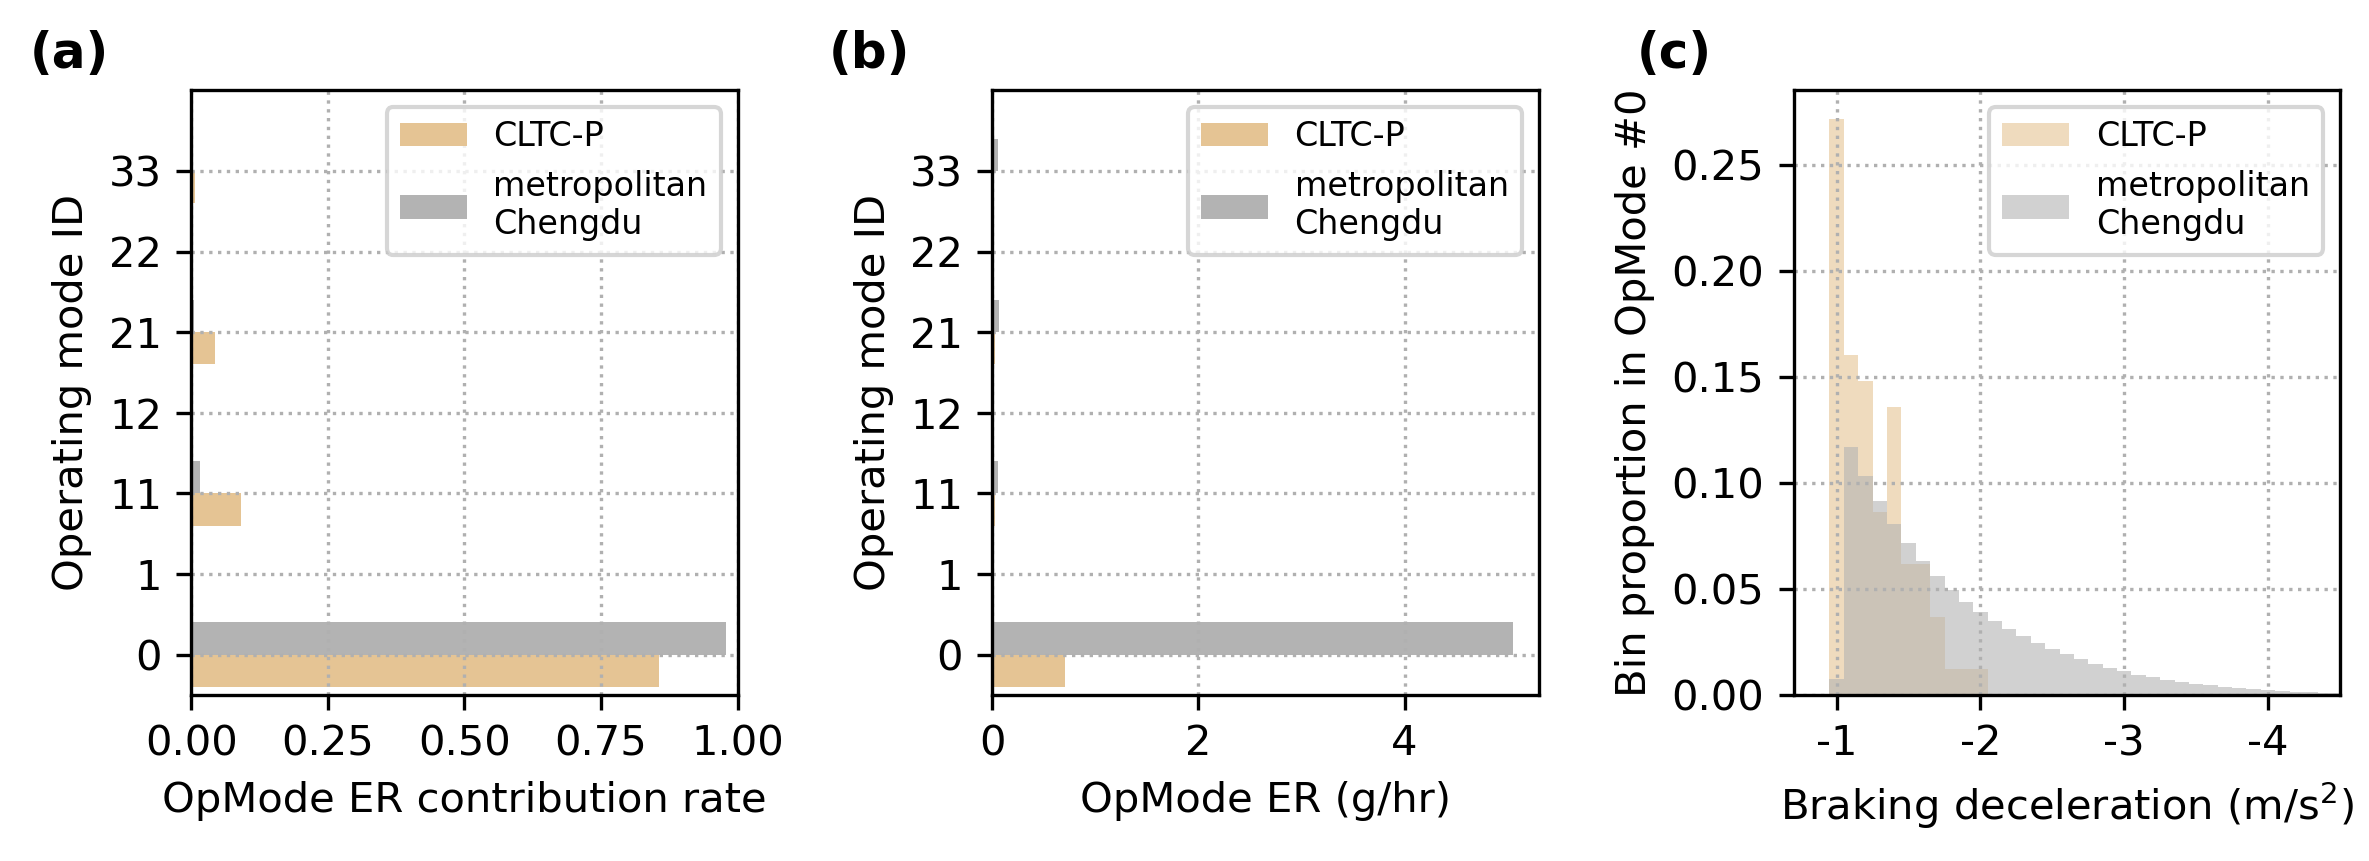

In [224]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,3))

color_cltc = set2_colors(6)
color_chengdu = set2_colors(7)
height = 0.4

# Add panel labels in Nature style (top-left corner, bold)
ax1.text(-0.15, 1.1, '(a)', transform=ax1.transAxes, 
         fontsize=12, fontweight='bold', va='top', ha='right')
ax2.text(-0.15, 1.1, '(b)', transform=ax2.transAxes, 
         fontsize=12, fontweight='bold', va='top', ha='right')
ax3.text(-0.15, 1.1, '(c)', transform=ax3.transAxes, 
         fontsize=12, fontweight='bold', va='top', ha='right')

# fig1: bar plot of opmode er cotribution rate
ax1.barh(np.arange(7)-height/2, opmode_er_contribution_cltc[[0,1,2,3,8,9,17]], color=color_cltc, height=height, label='CLTC-P')
ax1.barh(np.arange(7)+height/2, opmode_er_contribution_chengdu[[0,1,2,3,8,9,17]], color=color_chengdu, height=height, label='metropolitan\nChengdu')
ax1.set_xlabel('OpMode ER contribution rate')
ax1.set_ylabel('Operating mode ID')
ax1.set_yticks(np.arange(7), [0,1,11,12,21,22,33])
ax1.set_xlim(0, 1)
ax1.set_ylim(-0.5, 7)
ax1.grid(linestyle=':')
ax1.legend(loc='upper right', fontsize=8)

# fig2: bar plot of opmode er
ax2.barh(np.arange(7)-height/2, opmode_er_cltc['ICEV ERs'].mean()[[0,1,2,3,8,9,17]], color=color_cltc, height=height, label='CLTC-P')
ax2.barh(np.arange(7)+height/2, opmode_er_chengdu['ICEV ERs'].mean()[[0,1,2,3,8,9,17]], color=color_chengdu, height=height, label='metropolitan\nChengdu')
ax2.set_xlabel('OpMode ER (g/hr)')
ax2.set_ylabel('Operating mode ID')
ax2.set_yticks(np.arange(7), [0,1,11,12,21,22,33])
ax2.set_xlim(0,)
ax2.set_ylim(-0.5, 7)
ax2.grid(linestyle=':')
ax2.legend(loc='upper right', fontsize=8)

# fig3: distribution of deceleration of opmode 0
decel_0_cltc = opmode_CLTC.loc[0, 'brakeDecelBinProp']
decel_0_chengdu = opmode_Chengdu.loc[0, 'brakeDecelBinProp']
ax3.bar(np.arange(len(decel_0_cltc)), decel_0_cltc, color=color_cltc, alpha=0.6, width=1, label='CLTC-P')
ax3.bar(np.arange(len(decel_0_chengdu)), decel_0_chengdu, color=color_chengdu, alpha=0.6, width=1, label='metropolitan\nChengdu')
ax3.set_xlabel('Braking deceleration (m/s$^2$)')
ax3.set_ylabel('Bin proportion in OpMode #0')
ax3.set_xticks([5, 15, 25, 35, 45], [-4, -3, -2, -1, 0])
ax3.set_xlim(0, 38)
ax3.invert_xaxis()
ax3.grid(linestyle=':')
ax3.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()
fig.savefig('figures/cycle opmode comparison.jpg', bbox_inches='tight', dpi=1000)

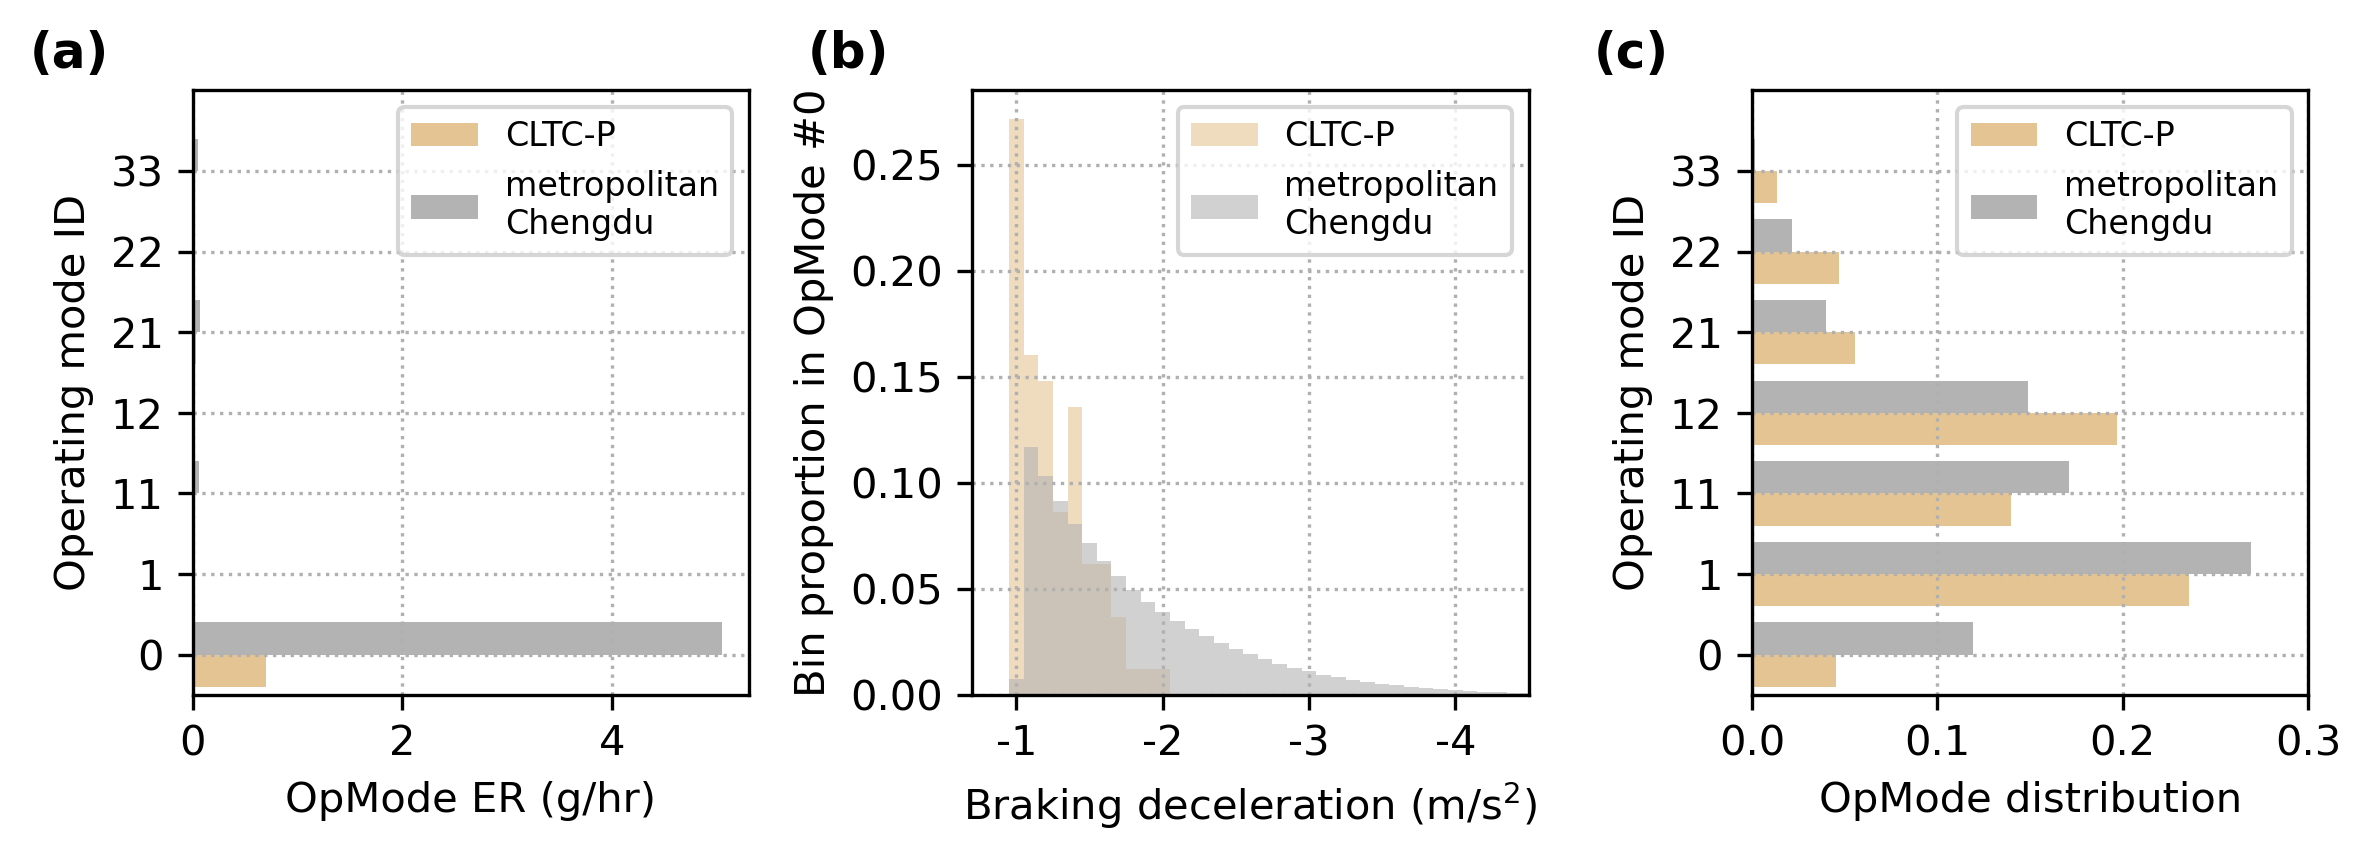

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,3))

color_cltc = set2_colors(6)
color_chengdu = set2_colors(7)
height = 0.4

# Add panel labels in Nature style (top-left corner, bold)
ax1.text(-0.15, 1.1, '(a)', transform=ax1.transAxes, 
         fontsize=12, fontweight='bold', va='top', ha='right')
ax2.text(-0.15, 1.1, '(b)', transform=ax2.transAxes, 
         fontsize=12, fontweight='bold', va='top', ha='right')
ax3.text(-0.15, 1.1, '(c)', transform=ax3.transAxes, 
         fontsize=12, fontweight='bold', va='top', ha='right')

# fig1: bar plot of opmode er
ax1.barh(np.arange(7)-height/2, opmode_er_cltc['ICEV ERs'].mean()[[0,1,2,3,8,9,17]], color=color_cltc, height=height, label='CLTC-P')
ax1.barh(np.arange(7)+height/2, opmode_er_chengdu['ICEV ERs'].mean()[[0,1,2,3,8,9,17]], color=color_chengdu, height=height, label='metropolitan\nChengdu')
ax1.set_xlabel('OpMode ER (g/hr)')
ax1.set_ylabel('Operating mode ID')
ax1.set_yticks(np.arange(7), [0,1,11,12,21,22,33])
ax1.set_xlim(0,)
ax1.set_ylim(-0.5, 7)
ax1.grid(linestyle=':')
ax1.legend(loc='upper right', fontsize=8)

# fig2: distribution of deceleration of opmode 0
decel_0_cltc = opmode_CLTC.loc[0, 'brakeDecelBinProp']
decel_0_chengdu = opmode_Chengdu.loc[0, 'brakeDecelBinProp']
ax2.bar(np.arange(len(decel_0_cltc)), decel_0_cltc, color=color_cltc, alpha=0.6, width=1, label='CLTC-P')
ax2.bar(np.arange(len(decel_0_chengdu)), decel_0_chengdu, color=color_chengdu, alpha=0.6, width=1, label='metropolitan\nChengdu')
ax2.set_xlabel('Braking deceleration (m/s$^2$)')
ax2.set_ylabel('Bin proportion in OpMode #0')
ax2.set_xticks([5, 15, 25, 35, 45], [-4, -3, -2, -1, 0])
ax2.set_xlim(0, 38)
ax2.invert_xaxis()
ax2.grid(linestyle=':')
ax2.legend(loc='upper right', fontsize=8)

# fig3: bar plot of opmode er cotribution rate
ax3.barh(np.arange(7)-height/2, opmode_dist_cltc.to_numpy()[[0,1,2,3,8,9,17]], color=color_cltc, height=height, label='CLTC-P')
ax3.barh(np.arange(7)+height/2, opmode_dist_chengdu.to_numpy()[[0,1,2,3,8,9,17]], color=color_chengdu, height=height, label='metropolitan\nChengdu')
ax3.set_xlabel('OpMode distribution')
ax3.set_ylabel('Operating mode ID')
ax3.set_yticks(np.arange(7), [0,1,11,12,21,22,33])
ax3.set_xlim(0, 0.3)
ax3.set_ylim(-0.5, 7)
ax3.grid(linestyle=':')
ax3.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()
fig.savefig('figures/cycle opmode comparison.jpg', bbox_inches='tight', dpi=1000)

In [20]:
opmode_dist_cltc.loc[[0,1,11]]

0        0.045
1     0.235556
11    0.139444
Name: trajCount, dtype: object